In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import numpy as np

In [2]:
FOUNDATIONS = ["authority", "care", "fairness", "loyalty", "sanctity"]
COLORS = ["darkviolet", "mediumblue", "mediumseagreen", "indianred", "goldenrod"]

## Load the training and test sets

For comparison

In [3]:
data = pd.read_csv("mfd/data/mfd_scoring_results/mf_merged_roberta.csv", index_col=0)
data.drop(columns=["tokens"], inplace=True)

def get_labels_and_scores(foundation, train=False, corpus="all", ground_truth=None):
    assert corpus in ["twitter", "reddit", "news", "all"]
    if corpus == "news": data_f = data.iloc[:34262,:]
    elif corpus == "reddit": data_f = data.iloc[34262:34262 + 17886, :]
    elif corpus == "twitter": data_f = data.iloc[34262 + 17886:, :]
    else: data_f = data
    if train:
        # Labels and predicted scores for the training examples
        data_f = data_f[data_f[f"{foundation}_fold"] != 0]
        data_f = data_f[data_f[f"{foundation}_fold"] != -1]
    else:
        # Labels and predicted scores for the test examples
        data_f = data_f[data_f[f"{foundation}_fold"] == 0]
    if ground_truth is not None:
        data_f = data_f[data_f[f"{foundation}_label"] == ground_truth]
    y_true = data_f[f"{foundation}_label"]
    y_score = data_f[f"{foundation}_score"]
    return y_true, y_score

## Load external datasets

In [4]:
# Only special to the vignettes dataset
vig = pd.read_csv("mfd/other_mf_corpora/vignettes_behvres2015/data/MF_vignettes_scored.csv", index_col=0)
for f in FOUNDATIONS + ["liberty", "not wrong"]:
    x = vig[f].tolist()
    x = [int(s[:-2]) / 100 for s in x]
    vig[f] = np.array(x)
f = vig["foundation"]
f = [s.lower() for s in f]
f_new = []
for s in f:
    if "(" in s:
        idx = s.index("(")
        s = s[:idx-1]
        f_new.append(s)
    else:
        f_new.append(s)
vig["foundation"] = f_new
vig = vig[vig["foundation"] != "liberty"]
for f in FOUNDATIONS:
    y_test = vig["foundation"]
    y_test = np.array([s == f for s in y_test], dtype=int)
    vig[f] = y_test

In [5]:
paths_to_corpora = {
    "mic": "mfd/other_mf_corpora/moral_integrity_acl2022/data/MIC_without_liberty_pred.csv",
    "argument": "mfd/other_mf_corpora/moral_argument_mining_2020/data/morality_arguments_pred.csv",
    "sc": "mfd/other_mf_corpora/social_chemistry_emnlp2020/data/social_chem_pred.csv",
    "vig": vig,
    "twitter_stance": "mfd/other_mf_corpora/twitter_stance_semeval2016/data/twitter_semeval2016_task6_scored.csv",
    "moral_frames": "mfd/other_mf_corpora/morality_frames_emnlp2021/data/moral_frames_dataset_roberta_annotated.csv",
    "condensed_vig": "mfd/other_mf_corpora/condensed_moral_vignettes_scan2010/data/condensed_moral_vignettes_scan2010_scored.csv",
    "jocn": "mfd/other_mf_corpora/harm_dishonesty_disgust_jocn2011/data/harm_dishonesty_disgust_dataset_scored.csv"
}
scored_corpora = {}
for k, v in paths_to_corpora.items():
    if k == "vig": 
        scored_corpora[k] = vig
    else:
        scored_corpora[k] = pd.read_csv(v)

## Comparing the distributions fo scores on the test set and on an external set 

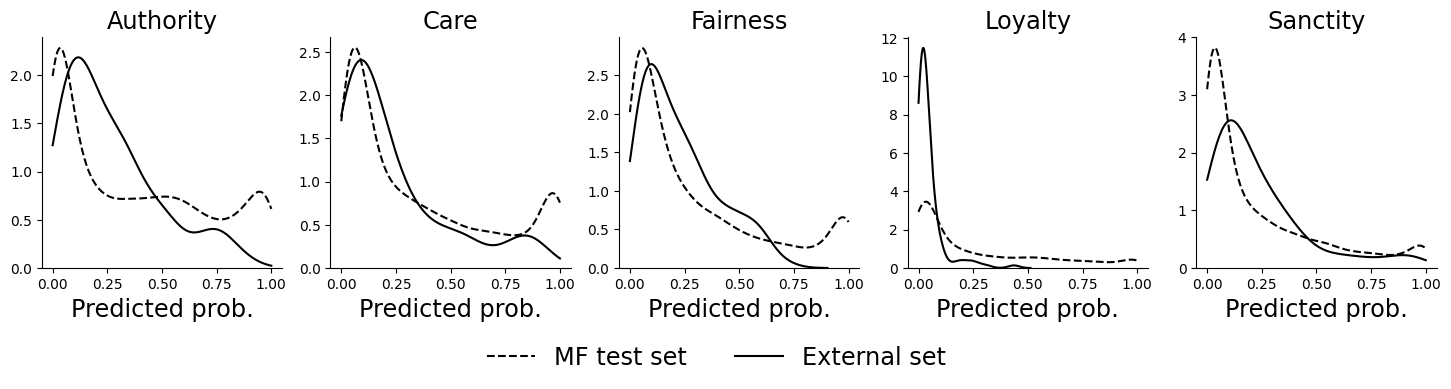

In [6]:
from matplotlib.lines import Line2D

# Change this name
corpus_name = "vig"

fig, axes = plt.subplots(1, len(FOUNDATIONS), figsize=(18, 3))
for ax, foundation, color in zip(axes, FOUNDATIONS, COLORS):
    # Get labels and predicted scores for the test set
    y_true, y_score = get_labels_and_scores(foundation, train=False)
    sns.kdeplot(y_score, ax=ax, clip=[0, 1], color="k", linestyle="--")
    ax.set_title(foundation.capitalize(), size="xx-large")
    ax.set_xlabel("Predicted prob.", size="xx-large")
    
    # Plot the same for the new dataset
    dataset = scored_corpora[corpus_name]
    y_score = dataset[foundation + "_score"]
    sns.kdeplot(y_score, ax=ax, color="k", linestyle="-", clip=[0, 1])
    ax.set_ylabel(None)

custom_lines = [Line2D([0], [0], color="k", linestyle="--"),
                Line2D([0], [0], color="k", linestyle="-")]
fig.legend(custom_lines, ['MF test set', 'External set'],
           frameon=False,
           ncol=2,
           prop={'size': "xx-large"},
           loc="lower center",
           bbox_to_anchor=(0.5, -0.3, 0, 0))
sns.despine()

## Thresholding to get binary labels

In [7]:
from utils.evaluation import evaluate_binary_scorer_fold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from utils.calibration import inverse_calibrate_saerens
from utils.thresholding import (
    threshold_max_diff_tpr_fpr,
    threshold_max_f1,
    threshold_max_gmean,
    threshold_top_x
)

In [8]:
# Change this name
corpus_name = "vig"

metric_df = pd.DataFrame(0, index=FOUNDATIONS, columns=[95, 90, 80, 70, 60, 50])
for foundation in FOUNDATIONS:
    dataset = scored_corpora[corpus_name]
    y_score = dataset[foundation + "_score"]
    for percentile in metric_df.columns:
        threshold = threshold_top_x(y_score, percentile)
        y_true = dataset[foundation]
        y_pred = np.array([y >= threshold for y in y_score], dtype=int)
        metric_df.loc[foundation, percentile] = f1_score(y_true=y_true, y_pred=y_pred)

In [9]:
metric_df

,95,90,80,70,60,50
authority,0.521739,0.689655,0.700000,0.576923,0.539683,0.453333
care,0.263158,0.454545,0.654545,0.626866,0.564103,0.555556
fairness,0.521739,0.551724,0.550000,0.538462,0.444444,0.426667
loyalty,0.454545,0.500000,0.410256,0.352941,0.354839,0.324324
sanctity,0.521739,0.689655,0.650000,0.538462,0.444444,0.400000


## Pulling out some examples

In [10]:
# Change these
corpus_name = "vig"
foundation = "loyalty"
threshold = 80

### True positives

In [11]:
dataset = scored_corpora[corpus_name]
y_true = dataset[foundation]
y_score = dataset[foundation + "_score"]
threshold = threshold_top_x(y_score, percentile)
y_pred = np.array([y >= threshold for y in y_score], dtype=int)

dataset = dataset[(y_true == 1) & (y_pred == 1)]

In [12]:
# Highest-scoring first
dataset.sort_values(f + "_score", ascending=False).head(5)["scenario"].tolist()

['You see a man secretly voting against his wife in a local beauty pageant.',
 'You see an American telling foreigners that the US is an evil force in the world.',
 "You see a Hollywood star agreeing with a foreign dictator's denunciation of the US.",
 'You see a former US General saying publicly he would never buy any American product.',
 'You see a former Secretary of State publicly giving up his citizenship to the US.']

### True negatives

In [13]:
dataset = scored_corpora[corpus_name]
y_true = dataset[foundation]
y_score = dataset[foundation + "_score"]
threshold = threshold_top_x(y_score, percentile)
y_pred = np.array([y >= threshold for y in y_score], dtype=int)

dataset = dataset[(y_true == 0) & (y_pred == 0)]

In [14]:
# Lowest-scoring first
dataset.sort_values(f + "_score", ascending=True).head(5)["scenario"].tolist()

['You see a teaching assistant talking back to the teacher in front of the classrom.',
 'You see someone reading the ending of a spy novel before reading the beginning.',
 'You see a man walking down a dark hallway while still wearing his sunglasses.',
 'You see a woman eating dessert before her main entree arrives on the table.',
 "You see a girl laughing when she realizes her friend's dad is the janitor."]

### False positives

In [15]:
# Change these
dataset = scored_corpora[corpus_name]
y_true = dataset[foundation]
y_score = dataset[foundation + "_score"]
threshold = threshold_top_x(y_score, percentile)
y_pred = np.array([y >= threshold for y in y_score], dtype=int)

dataset = dataset[(y_true == 0) & (y_pred == 1)]

In [16]:
# Highest-scoring first
dataset.sort_values(f + "_score", ascending=False).head(5)["scenario"].tolist()

['You see a woman having intimate relations with a recently deceased loved one.',
 'You see a boy setting a series of traps to kill stray cats in his neighborhood.',
 'You see a teenage girl openly staring at a disfigured woman as she walks past.',
 'You see someone cheating in a card game while playing with a group of strangers.',
 'You see a boy throwing rocks at cows that are grazing in the local pasture.']

### False negatives

In [17]:
dataset = scored_corpora[corpus_name]
y_true = dataset[foundation]
y_score = dataset[foundation + "_score"]
threshold = threshold_top_x(y_score, percentile)
y_pred = np.array([y >= threshold for y in y_score], dtype=int)

dataset = dataset[(y_true == 1) & (y_pred == 0)]

In [18]:
# Lowest-scoring first
dataset.sort_values(f + "_score", ascending=True).head(5)["scenario"].tolist()

['You see a mayor saying that the neighboring town is a much better town.',
 'You see a teacher publicly saying she hopes another school wins the math contest.',
 'You see the US Ambassador joking in Great Britain about the stupidity of Americans.',
 'You see an employee joking with competitors about how bad his company did last year.']